In [1]:
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
import pandas as pd
import seaborn as sns
import pennylane as qml
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input
from keras.optimizers import Adam
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.regularizers import l2
from imblearn.over_sampling import SMOTE
from qiskit.algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler                             
from qiskit_machine_learning.algorithms.classifiers import VQC 
from IPython.display import clear_output
import matplotlib.pyplot as plt
import time, copy, warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

data = pd.read_csv('C:/Users/RDSC/downloads/FLC_labeled_notime.csv', sep=';')



# Display the first few rows of the dataset to understand its structure
print(data.head())






   open  high   low  close    Volume   Volume MA  manipulated
0  4700  4700  4580   4600  15576400  12083646.0            0
1  4520  4600  4480   4490  18797400  12559327.5            0
2  4500  4530  4380   4390  22116400  13069294.0            0
3  4380  4550  4380   4430  13101500  13310592.0            0
4  4480  4550  4430   4440  12386000  13530883.5            0


In [2]:
# Convert the data into a DataFrame
df = pd.DataFrame(data)

# Step 2: Explore the dimensions
print("Number of rows and columns:", df.shape)

Number of rows and columns: (329, 7)


In [3]:
# Convert the data into a DataFrame
df = pd.DataFrame(data)

# Step 1: Handling Missing Values (if any)
# Check for missing values in the DataFrame
print(df.isnull().sum())



open           0
high           0
low            0
close          0
Volume         0
Volume MA      0
manipulated    0
dtype: int64


In [4]:
#If there are any missing values, you can impute them with the mean, median, or mode.
# For example, to impute missing values with the mean:
df.fillna(df.mean(), inplace=True)

# Specify the column for which you want to check outliers
column_name = 'manipulated' 

# Calculate the mean and standard deviation of the column
mean = df[column_name].mean()
std = df[column_name].std()

# Define the threshold for identifying outliers (e.g., z-score > 3)
threshold = 3

# Initialize a list to store outliers
outliers = []

# Calculate the z-score for each value in the column and identify outliers
for index, value in df[column_name].iteritems():
    z_score = (value - mean) / std
    if z_score > threshold:
        outliers.append(value)

print('Outliers in the dataset:', outliers)

Outliers in the dataset: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [5]:
nonfraud_count = data[data.manipulated == 0]
fraud_count = data[data.manipulated == 1]


num_normal = nonfraud_count.shape[0] 
num_fraud = fraud_count.shape[0] 

print(f"Number of normal examples = {num_normal}")
print(f"Number of fraud examples = {num_fraud}\n")


ratio = num_normal/num_fraud
print(f'normal to fraud ratio in the whole data = {round(ratio,2)}')

Number of normal examples = 301
Number of fraud examples = 28

normal to fraud ratio in the whole data = 10.75


## Undersampling 

In [6]:
# normal_fraud_ratio = 1 means balance sample
normal_fraud_ratio = 1                                     
normal_sample = nonfraud_count.sample(normal_fraud_ratio*num_fraud) 


# The code concatenates the fraud cases from the fraud_count DataFrame and the balanced normal cases from normal_sample to 
# create a new DataFrame called sample. The resulting sample DataFrame now has a balanced class distribution.

sample = pd.concat([fraud_count, normal_sample], axis=0)  

# random shuffling of sample examples 100 times
for i in range(100):
    sample = np.random.permutation(sample)                   


    


In [7]:
sample.shape

(56, 7)

In [8]:
#The variable X contains the feature values from the sample DataFrame, excluding the last column, 
#which contains the class labels (0 or 1).The variable y contains the class labels from the last column of the sample DataFrame.

X, y = sample[:, :-1], sample[:, -1]

# feature scaling
X = MinMaxScaler().fit_transform(X)            

num_examples, num_features = X.shape   
print("number of examples = ", num_examples)
print("number of features = ", num_features)


X[:,:] , y[:]


number of examples =  56
number of features =  6


(array([[0.53703704, 0.5257732 , 0.59805116, 0.56267409, 0.09085731,
         0.67889128],
        [0.32804233, 0.32474227, 0.3727162 , 0.33983287, 0.0776408 ,
         0.09349391],
        [0.54497354, 0.54896907, 0.59500609, 0.58774373, 0.38925645,
         0.71499668],
        [0.47619048, 0.46391753, 0.51583435, 0.47075209, 0.10948115,
         0.74587073],
        [0.18783069, 0.19587629, 0.22350792, 0.20334262, 0.13498247,
         0.54713718],
        [0.55026455, 0.58505155, 0.63459196, 0.63788301, 0.23046056,
         0.59930109],
        [0.73809524, 0.74484536, 0.84165652, 0.78272981, 0.19143167,
         0.50487922],
        [0.56084656, 0.55412371, 0.62850183, 0.57938719, 0.11970997,
         0.62172372],
        [0.32010582, 0.33247423, 0.36662607, 0.36490251, 0.12278432,
         0.90150281],
        [0.38624339, 0.39690722, 0.42752741, 0.41225627, 0.21216038,
         0.97992231],
        [0.81746032, 0.86082474, 0.93605359, 0.91922006, 0.29790143,
         0.60955767],

In [9]:
''' 
Zero padding is to make the number of features equal to a power of 2.
it is required for 'amplitude encoding' given below.
'''

n = int(np.ceil(np.log2(num_features)))
dim = 2**n
print(f'(number of qubits, dimension of the Hilbert space) = {(n, dim)}')

zeros = np.zeros((num_examples, dim-num_features))
X = np.append(X, zeros, axis=1)
num_examples, num_features = X.shape

num_examples, num_features = X.shape   
print("number of examples = ", num_examples)
print("number of features = ", num_features)

(number of qubits, dimension of the Hilbert space) = (3, 8)
number of examples =  56
number of features =  8


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print(X_train.shape, X_test.shape ,  y_train.shape, y_test.shape)

(39, 8) (17, 8) (39,) (17,)


## Model Building

In [11]:
from qiskit_machine_learning.circuit.library import RawFeatureVector


fm = RawFeatureVector(feature_dimension=num_features) 
fm.draw() 

┌───────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                                  ├
     │                                                                   │
q_1: ┤1 Parameterizedinitialize(x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7]) ├
     │                                                                   │
q_2: ┤2                                                                  ├
     └───────────────────────────────────────────────────────────────────┘

In [12]:
from qiskit.circuit.library import RealAmplitudes


'''
For amplitude encoding, num_qubits = n = np.log2(num_features)
'''

pqc = RealAmplitudes(num_qubits=n, reps= 4)
pqc.decompose().draw()

┌──────────┐                 ┌──────────┐                 ┌──────────┐»
q_0: ┤ Ry(θ[0]) ├──────────■──────┤ Ry(θ[3]) ├──────────■──────┤ Ry(θ[6]) ├»
     ├──────────┤        ┌─┴─┐    ├──────────┤        ┌─┴─┐    ├──────────┤»
q_1: ┤ Ry(θ[1]) ├──■─────┤ X ├────┤ Ry(θ[4]) ├──■─────┤ X ├────┤ Ry(θ[7]) ├»
     ├──────────┤┌─┴─┐┌──┴───┴───┐└──────────┘┌─┴─┐┌──┴───┴───┐└──────────┘»
q_2: ┤ Ry(θ[2]) ├┤ X ├┤ Ry(θ[5]) ├────────────┤ X ├┤ Ry(θ[8]) ├────────────»
     └──────────┘└───┘└──────────┘            └───┘└──────────┘            »
«                        ┌──────────┐                  ┌───────────┐
«q_0: ───────────■───────┤ Ry(θ[9]) ├───────────■──────┤ Ry(θ[12]) ├
«              ┌─┴─┐    ┌┴──────────┤         ┌─┴─┐    ├───────────┤
«q_1: ──■──────┤ X ├────┤ Ry(θ[10]) ├──■──────┤ X ├────┤ Ry(θ[13]) ├
«     ┌─┴─┐┌───┴───┴───┐└───────────┘┌─┴─┐┌───┴───┴───┐└───────────┘
«q_2: ┤ X ├┤ Ry(θ[11]) ├─────────────┤ X ├┤ Ry(θ[14]) ├─────────────
«     └───┘└───────────┘             └───┘└───────────┘

In [13]:
optimizer = COBYLA(maxiter=150)                 
sampler = Sampler()




objective_func_vals = []
                                    
def callback(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()


vqc = VQC(
    sampler=sampler,
    feature_map=fm,
    ansatz=pqc,
    optimizer=optimizer,
    callback=callback,
)

## Training and evaluating performance 

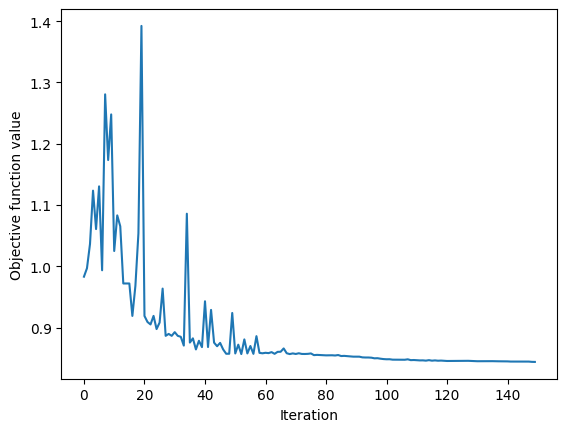

Wall time: 2min 22s


In [14]:
%%time

vqc.fit(X_train, y_train)

In [15]:
y_test_pred = vqc.predict(X_test)


print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred), "= confusion matrix for test set \n ")


              precision    recall  f1-score   support

         0.0       1.00      0.78      0.88         9
         1.0       0.80      1.00      0.89         8

    accuracy                           0.88        17
   macro avg       0.90      0.89      0.88        17
weighted avg       0.91      0.88      0.88        17

[[7 2]
 [0 8]] = confusion matrix for test set 
 


In [16]:
print(y_test_pred)

[1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1.]


In [17]:
print(y_test)

[1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1.]
